<html>
<head>
	<title></title>
</head>
<body>
<h2 style="text-align: center;line-height: 120%;">ФЕДЕРАЛЬНОЕ ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ ОБРАЗОВАТЕЛЬНОЕ УЧРЕЖДЕНИЕ ВЫСШЕГО ОБРАЗОВАНИЯ НАЦИОНАЛЬНЫЙ ИССЛЕДОВАТЕЛЬСКИЙ УНИВЕРСИТЕТ «МОСКОВСКИЙ ЭНЕРГЕТИЧЕСКИЙ ИНСТИТУТ» Кафедра «РЗиАЭ»</h2>
<h2 style="text-align: center;line-height: 20%;">Лабораторная работа №4</h2>

<h3 style="text-align: center;line-height: 80%;"><em>Глубокое обучение для прогнозирования временного ряда.</em></h3>

<p style="text-align: right;line-height: 40%;">Выполнил: студент группы Э-13м-19</p>

<p style="text-align: right;line-height: 40%;">Шмыков А.Д.</p>

<p style="text-align: right;line-height: 40%;">Проверил: Нухулов С.М.</p>
<h4 style="text-align: center;line-height: 100%;"><em> Москва, 2020</em></h3>
</body>
</html>

<h3> П1 Загрузка анализируемых данных csv и подсчёт пропущенных значений. </h3>

In [345]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
from tensorflow.python.keras.utils import np_utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.python.keras.utils import np_utils
from sklearn.preprocessing import StandardScaler


In [361]:
data=pd.read_csv(r"C:\Users\1\Downloads\AEP_hourly.csv")
data=data.set_index('Datetime')
data

,AEP_MW
Datetime,
2004-12-31 01:00:00,13478.0
2004-12-31 02:00:00,12865.0
2004-12-31 03:00:00,12577.0
2004-12-31 04:00:00,12517.0
2004-12-31 05:00:00,12670.0
...,...
2018-01-01 20:00:00,21089.0
2018-01-01 21:00:00,20999.0
2018-01-01 22:00:00,20820.0


<h3> П2 Нормализация временного ряда </h3>


In [362]:
scaler=StandardScaler()
data_scaled=scaler.fit_transform(data)
# data_scaled=data.to_numpy()
means=scaler.mean_
std=scaler.scale_


<h3> П3 Написать функцию-генератор, формирующую окна из временного ряда (data).</h3>

In [363]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index: #если превысили, считаем заново(когда наступает след.эпоха)
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index)) #окно 168-311(=144)
            i += len(rows) #+=128

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows): # j=0-batch_size row=168...end
            
            indices = range(rows[j] - lookback, rows[j], step)#168-lookback,168
                                                                #169-lookback,169
   
            samples[j] = data[indices] #окно 0-168 1-169 2-170... кол-во окон=batch_size 
            targets[j] = data[rows[j] + delay][0] #цена на след.день после 7ми дней
        yield samples, targets

<h3> П4 Инициализировать генераторы для: обучения, валидации,
тестирования.</h3>

In [366]:
lookback=168
step=1
delay=0
batch_size=128
train_split=int(0.6*len(data_scaled))
train=train_split-(train_split%batch_size)
val_split=int(0.8*len(data_scaled))
val=val_split-(val_split%batch_size)
test_split=(len(data_scaled))
test=test_split-(test_split%batch_size)
train_gen = generator(data_scaled,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=train,
                      shuffle=False,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(data_scaled,
                    lookback=lookback,
                    delay=delay,
                    min_index=train+1,
                    max_index=val,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(data_scaled,
                    lookback=lookback,
                    delay=delay,
                    min_index=val+1,
                    max_index=test+1,
                    step=step,
                    batch_size=batch_size)
val_steps=(val-train-1-lookback)//batch_size
#Сколько раз нужно обратится к тест.выборке
test_steps=(test+1-val-1)//batch_size
lookback // step, data_scaled.shape[-1]

(168, 1)

<h3> П5 Проверить качество базового решения задачи прогнозирования
без привлечения машинного обучения, предполагая, что следующее значение
временного ряда равно фактическому значению предыдущего шага.
Рассчитать среднюю и среднюю абсолютную ошибки. Визуализировать
спрогнозированный и фактические временные ряды на одном графике.</h3>

Расчёт средней абсолютной ошибки

In [357]:
maes=[]
pred=[]
targets_array=[]
for step in range(val_steps):
    #за итерацию предсказание-предыдущее от target
    samples,targets=next(val_gen) #samples- 0...168 1...169 до 128...296 (128 окон по 168 замерам)
    preds=samples[:,-1,0] # окно после lookback, т.еот min_index+lookback
    mae=np.mean(np.abs(preds-targets)) #targets- окно lookback+delay 
    maes.append(mae)
    pred.append(preds)
    targets_array.append(targets)

print('Средняя абс.ошибка ',np.mean(maes))


Средняя абс.ошибка  0.170341553659737


In [358]:
targets_array=np.asarray(targets_array)
pred=np.asarray(pred)
print(targets_array.shape)
print(pred.shape)
val_true = targets_array.reshape(len(targets_array)*batch_size)
val_pred = pred.reshape(len(pred)*batch_size)


(187, 128)
(187, 128)


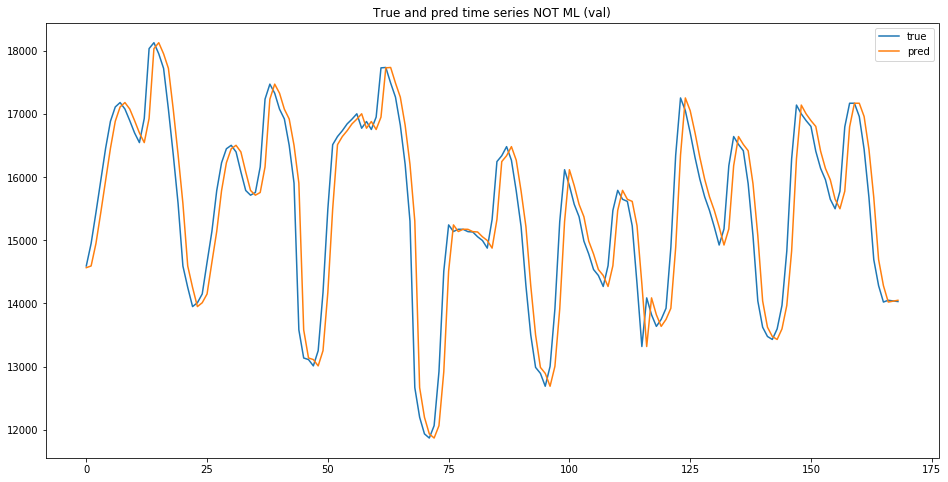

In [359]:
for i in  range(len(val_true)):
    val_true[i]=(val_true[i]*std[0])+means[0]
    val_pred[i]=(val_pred[i]*std[0])+means[0]
x = np.linspace(0,168,168,dtype=int)
plt.figure(figsize=(16,8))
plt.plot(x, val_true[:168])
plt.plot(x, val_pred[:168])
plt.title('True and pred time series NOT ML (val)')
plt.legend(['true','pred'],loc='upper right')
plt.show()

Расчёт средней ошибки

In [360]:
mes = []
preds_series = []
targets_series = []
for step in range(val_steps):
    samples, targets = next(val_gen)
    targets_series.append(targets)
    preds = samples[:, -1, 0]
    preds_series.append(preds)
    me = np.mean(preds - targets)
    mes.append(me)
print('Средняя ошибка ',np.mean(mes))


Средняя ошибка  -1.3864824217491253e-06


<h3> П6
Обучить многослойный перцептрон для прогнозирования
временного ряда. Рассчитать среднюю и среднюю абсолютную ошибки.
Визуализировать спрогнозированный и фактические временные ряды на
одном графике.</h3>

In [319]:
from tensorflow.keras.layers import Flatten 
model = Sequential() 
model.add(Flatten(input_shape=(lookback // step, data_scaled.shape[-1]))) 
model.add(Dense(32, activation='relu'))
model.add(Dense(1))
model.summary()
model.compile(loss='mae', optimizer='adam') 
history = model.fit(train_gen,
                              steps_per_epoch=100,
                              epochs=30,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_11 (Flatten)         (None, 168)               0         
_________________________________________________________________
dense_28 (Dense)             (None, 32)                5408      
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 33        
Total params: 5,441
Trainable params: 5,441
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
100/100 [==============================] - 2s 25ms/step - loss: 0.6255 - val_loss: 0.3861
Epoch 2/30
100/100 [==============================] - 2s 25ms/step - loss: 0.2995 - val_loss: 0.2652
Epoch 3/30
100/100 [==============================] - 2s 25ms/step - loss: 0.2626 - val_loss: 0.2948
Epoch 4/30
100/100 [==============================] - 2s 25ms/step - loss: 0.2

In [320]:
arr=model.predict_generator(test_gen,steps=test_steps).flatten()
inversed_real_test = scaler.inverse_transform(data_scaled)[val+1:test+1,0]

In [322]:
test_arr=model.predict_generator(test_gen,steps=test_steps)

test_maes = []
for ii in range(test_steps):
    samples, targets = next(test_gen)
    mae = np.mean(np.abs(test_arr - targets))
    test_maes.append(mae)
print(np.mean(test_maes))

1.0428931554403336


In [272]:
for i in  range(len(arr)):
    arr[i]=(arr[i]*std[0])+means[0]


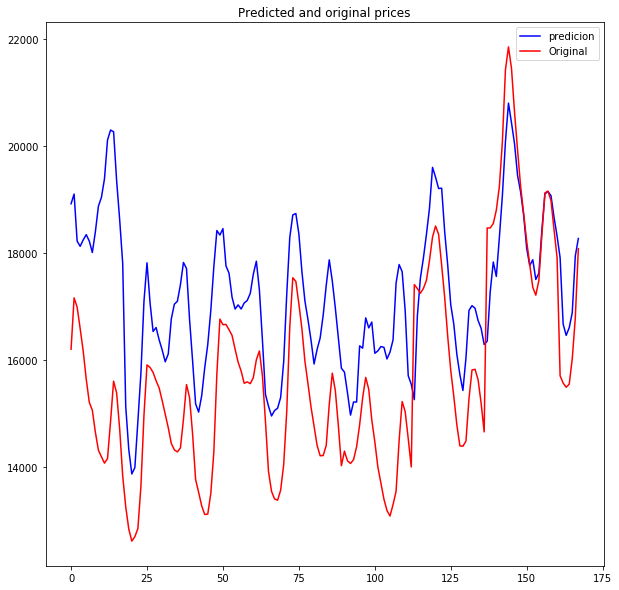

In [273]:
epochs = range(168)

plt.figure(figsize=(10,10))
plt.plot(epochs, arr[:168], 'b', label='predicion')
plt.plot(epochs, inversed_real_test[:168], 'r', label='Original')
plt.title('Predicted and original prices')
plt.legend()

plt.show()

<h3> П7 Обучить сверточную сеть прогнозирования временного ряда.
Рассчитать среднюю и среднюю абсолютную ошибки. Визуализировать
спрогнозированный и фактические временные ряды на одном графике.;</h3>

In [332]:
from keras.layers import Conv1D
model = Sequential()
model.add(Conv1D(filters=16, kernel_size=3, activation='relu',
                input_shape=(lookback // step, data_scaled.shape[-1])))
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(15, activation='relu'))
model.add(Dense(1))
model.summary()
model.compile(loss='mae', optimizer='adam') 
history = model.fit(train_gen,
                              steps_per_epoch=100,
                              epochs=30,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 166, 16)           64        
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 164, 32)           1568      
_________________________________________________________________
flatten_12 (Flatten)         (None, 5248)              0         
_________________________________________________________________
dense_30 (Dense)             (None, 32)                167968    
_________________________________________________________________
dense_31 (Dense)             (None, 15)                495       
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 16        
Total params: 170,111
Trainable params: 170,111
Non-trainable params: 0
_______________________________________________

In [333]:
test_arr=model.predict_generator(test_gen,steps=test_steps)

test_maes = []
for ii in range(test_steps):
    samples, targets = next(test_gen)
    mae = np.mean(np.abs(test_arr - targets))
    test_maes.append(mae)
print(np.mean(test_maes))

1.0472680307357403


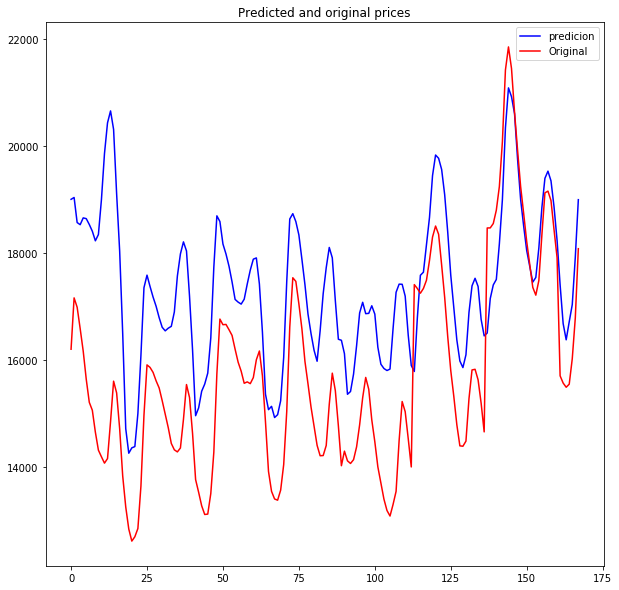

In [282]:
arr=model.predict_generator(test_gen,steps=test_steps).flatten()
inversed_real_test = scaler.inverse_transform(data_scaled)[val+1:test+1,0]
for i in  range(len(arr)):
    arr[i]=(arr[i]*std[0])+means[0]
epochs = range(168)

plt.figure(figsize=(10,10))
plt.plot(epochs, arr[:168], 'b', label='predicion')
plt.plot(epochs, inversed_real_test[:168], 'r', label='Original')
plt.title('Predicted and original prices')
plt.legend()

plt.show()

<h3> П8 Обучить рекуррентную сеть с одним рекуррентным слоем для
прогнозирования временного ряда. Рассчитать среднюю и среднюю
абсолютную ошибки. Визуализировать спрогнозированный и фактические
временные ряды на одном графике.</h3>

In [288]:
from keras.layers import GRU

model = Sequential()
model.add(GRU(32, input_shape=(None, data_scaled.shape[-1])))
model.add(Dense(1))
model.summary()
model.compile(loss='mae', optimizer='adam') 
history = model.fit(train_gen,
                              steps_per_epoch=100,
                              epochs=30,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 32)                3360      
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 33        
Total params: 3,393
Trainable params: 3,393
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
100/100 [==============================] - 15s 149ms/step - loss: 0.4823 - val_loss: 0.3014
Epoch 2/30
100/100 [==============================] - 15s 145ms/step - loss: 0.2506 - val_loss: 0.1920
Epoch 3/30
100/100 [==============================] - 15s 145ms/step - loss: 0.1888 - val_loss: 0.1739
Epoch 4/30
100/100 [==============================] - 15s 145ms/step - loss: 0.1589 - val_loss: 0.1397
Epoch 5/30
100/100 [==============================] - 15s 148ms/step - loss: 0.1400 - val_loss: 0.139

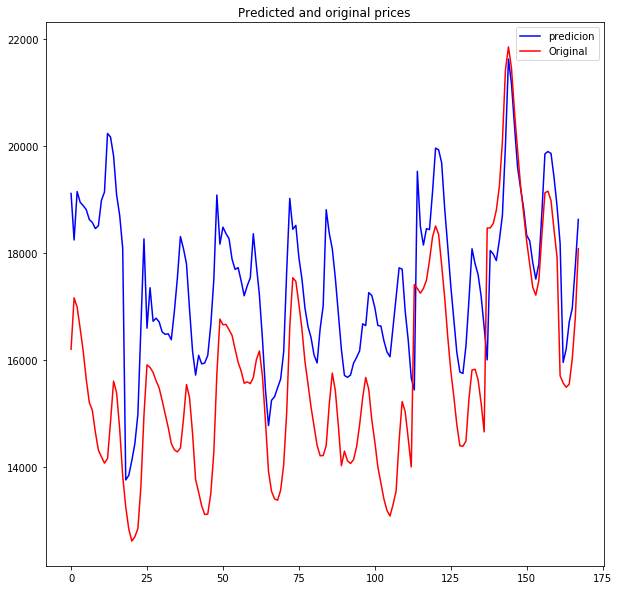

In [289]:
arr=model.predict_generator(test_gen,steps=test_steps).flatten()
inversed_real_test = scaler.inverse_transform(data_scaled)[val+1:test+1,0]
for i in  range(len(arr)):
    arr[i]=(arr[i]*std[0])+means[0]
epochs = range(168)

plt.figure(figsize=(10,10))
plt.plot(epochs, arr[:168], 'b', label='predicion')
plt.plot(epochs, inversed_real_test[:168], 'r', label='Original')
plt.title('Predicted and original prices')
plt.legend()

plt.show()

<h3> П9 Два рекуррентных слоя.</h3>

In [309]:
model = Sequential()
model.add(GRU(32,
             return_sequences=True,
             input_shape=(None, data_scaled.shape[-1])))
model.add(GRU(32, activation='relu'))
model.add(Dense(1))
model.summary()
model.compile(loss='mae', optimizer='adam') 
history = model.fit(train_gen,
                              steps_per_epoch=100,
                              epochs=10,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_5 (GRU)                  (None, None, 32)          3360      
_________________________________________________________________
gru_6 (GRU)                  (None, 32)                6336      
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 33        
Total params: 9,729
Trainable params: 9,729
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
100/100 [==============================] - 31s 310ms/step - loss: 0.4089 - val_loss: 39646.5352
Epoch 2/10
100/100 [==============================] - 30s 295ms/step - loss: 6.4961 - val_loss: 0.2077
Epoch 3/10
100/100 [==============================] - 32s 320ms/step - loss: 0.1950 - val_loss: 0.1993
Epoch 4/10
100/100 [==============================] - 35s 352ms/step

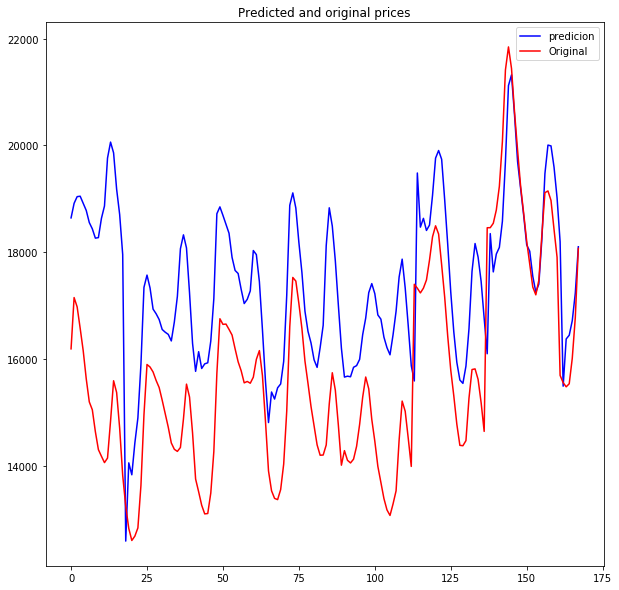

In [310]:
arr=model.predict_generator(test_gen,steps=test_steps).flatten()
inversed_real_test = scaler.inverse_transform(data_scaled)[val+1:test+1,0]
for i in  range(len(arr)):
    arr[i]=(arr[i]*std[0])+means[0]
epochs = range(168)

plt.figure(figsize=(10,10))
plt.plot(epochs, arr[:168], 'b', label='predicion')
plt.plot(epochs, inversed_real_test[:168], 'r', label='Original')
plt.title('Predicted and original prices')
plt.legend()

plt.show()

<h3> П10 Два рекуррентных слоя с прореживанием.</h3>


In [311]:
model = Sequential()
model.add(GRU(32,
             dropout=0.1,
             recurrent_dropout=0.5,
             return_sequences=True,
             input_shape=(None, data_scaled.shape[-1])))
model.add(GRU(32, activation='relu',
             dropout = 0.1,
             recurrent_dropout = 0.5))
model.add(Dense(1))
model.summary()
model.compile(loss='mae', optimizer='adam') 
history = model.fit(train_gen,
                              steps_per_epoch=100,
                              epochs=10,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_7 (GRU)                  (None, None, 32)          3360      
_________________________________________________________________
gru_8 (GRU)                  (None, 32)                6336      
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 33        
Total params: 9,729
Trainable params: 9,729
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
100/100 [==============================] - 46s 464ms/step - loss: 0.4700 - val_loss: 0.2812
Epoch 2/10
100/100 [==============================] - 48s 481ms/step - loss: 0.2905 - val_loss: 0.1749
Epoch 3/10
100/100 [==============================] - 48s 477ms/step - loss: 0.2673 - val_loss: 0.2404
Epoch 4/10
100/100 [==============================] - 45s 454ms/step - l

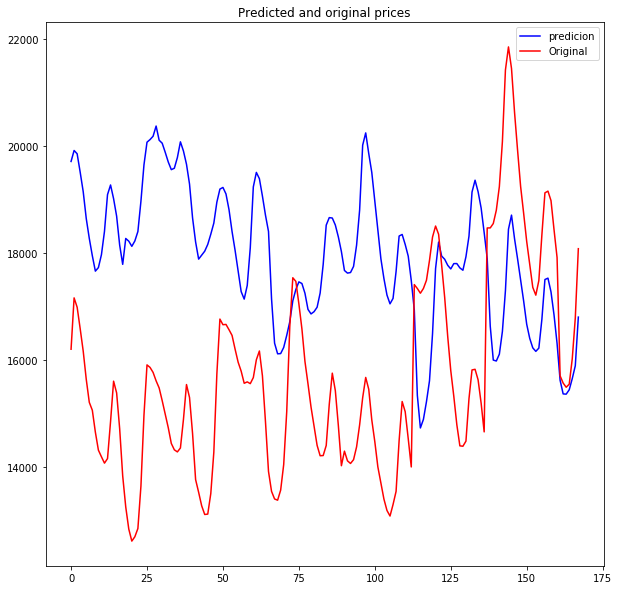

In [313]:
arr=model.predict_generator(test_gen,steps=test_steps).flatten()
inversed_real_test = scaler.inverse_transform(data_scaled)[val+1:test+1,0]
for i in  range(len(arr)):
    arr[i]=(arr[i]*std[0])+means[0]
epochs = range(168)

plt.figure(figsize=(10,10))
plt.plot(epochs, arr[:168], 'b', label='predicion')
plt.plot(epochs, inversed_real_test[:168], 'r', label='Original')
plt.title('Predicted and original prices')
plt.legend()

plt.show()

<h3>Вывод</h3> 
В работе была рассмотрена работа многослойного перцептрона, РНС и сверточной сетей. Перцептрон показал наихудший результат по средней абсолютной ошибке, однако время обучения самое короткое. Плохой результат объясняется периодичностью данных, которые следует запоминать для правильного прогноза. Также время увеличилось при добавлении второго рекуррентного слоя. Можно сказать, что перцептрон справился с задачей лучше, так как время минимально.